# Predicting Spotify Song Popularity

*Emanie Luu, Anton Conrad, Augustin Cramer, Antoine Dalenconte and Martin Bordes*

<div>
<table style="width:50%; background-color:white;">
  <tr style="background-color:transparent;">
    <td align="center"; style="background-color:transparent; width: 30%;">
        <img src="img/ip_paris.png" width="450px"/>
    </td>
  </tr>
 </table>
</div>


## Introduction

In today's digital age, music streaming platforms have revolutionized the way we consume music. Among these platforms, Spotify stands out as one of the most popular, offering users access to millions of tracks across various genres. With such an extensive library at our fingertips, understanding what makes a track popular on Spotify becomes an intriguing data science problem.

In this challenge, participants will delve into the rich dataset provided by Spotify, aiming to predict the popularity of tracks based on a diverse set of features. These features encompass various aspects, ranging from acoustic characteristics to the artist's popularity and the track's release date. By leveraging machine learning techniques, participants will uncover the underlying patterns that drive a track's success on this prominent music streaming platform.

The primary objective of this challenge is to develop robust predictive models that accurately estimate the popularity of tracks on Spotify. Popularity, in this context, is a metric provided by Spotify, reflecting the relative popularity of a track based on factors such as the number of listens and user interactions.

Participants will utilize a combination of data preprocessing, feature engineering, and machine learning algorithms to create predictive models. The performance of these models will be evaluated based on established metrics, with an emphasis on predictive accuracy and generalization to unseen data.

## Requirements

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from problem import get_train_data, get_test_data

## Data exploration

In [30]:
pd.set_option("display.max_columns", 30)

In [31]:
X_train = pd.read_csv("data/X_train.csv", index_col=0)
y_train = pd.read_csv("data/y_train.csv", index_col=0)
X_test = pd.read_csv("data/X_test.csv", index_col=0)
y_test = pd.read_csv("data/y_test.csv", index_col=0)

Data consists of two types of columns, those that identify the song (such as the artist, the title) and information on the music itself. We are here interested in the last category since there are the ones you will use as features in your models. We can separate them between the numerical features and the categorical ones.

In [32]:
numeric_features = [
    "danceability",
    "energy",
    "key",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
]

categorical_features = ["playlist_genre", "playlist_subgenre", "mode"]

We can observe the training set contains 23 639 samples, with 22 covariates each (we will only use 14 of them)

In [33]:
X_train.shape

(23639, 22)

We can look at the distribution of numerical features : 

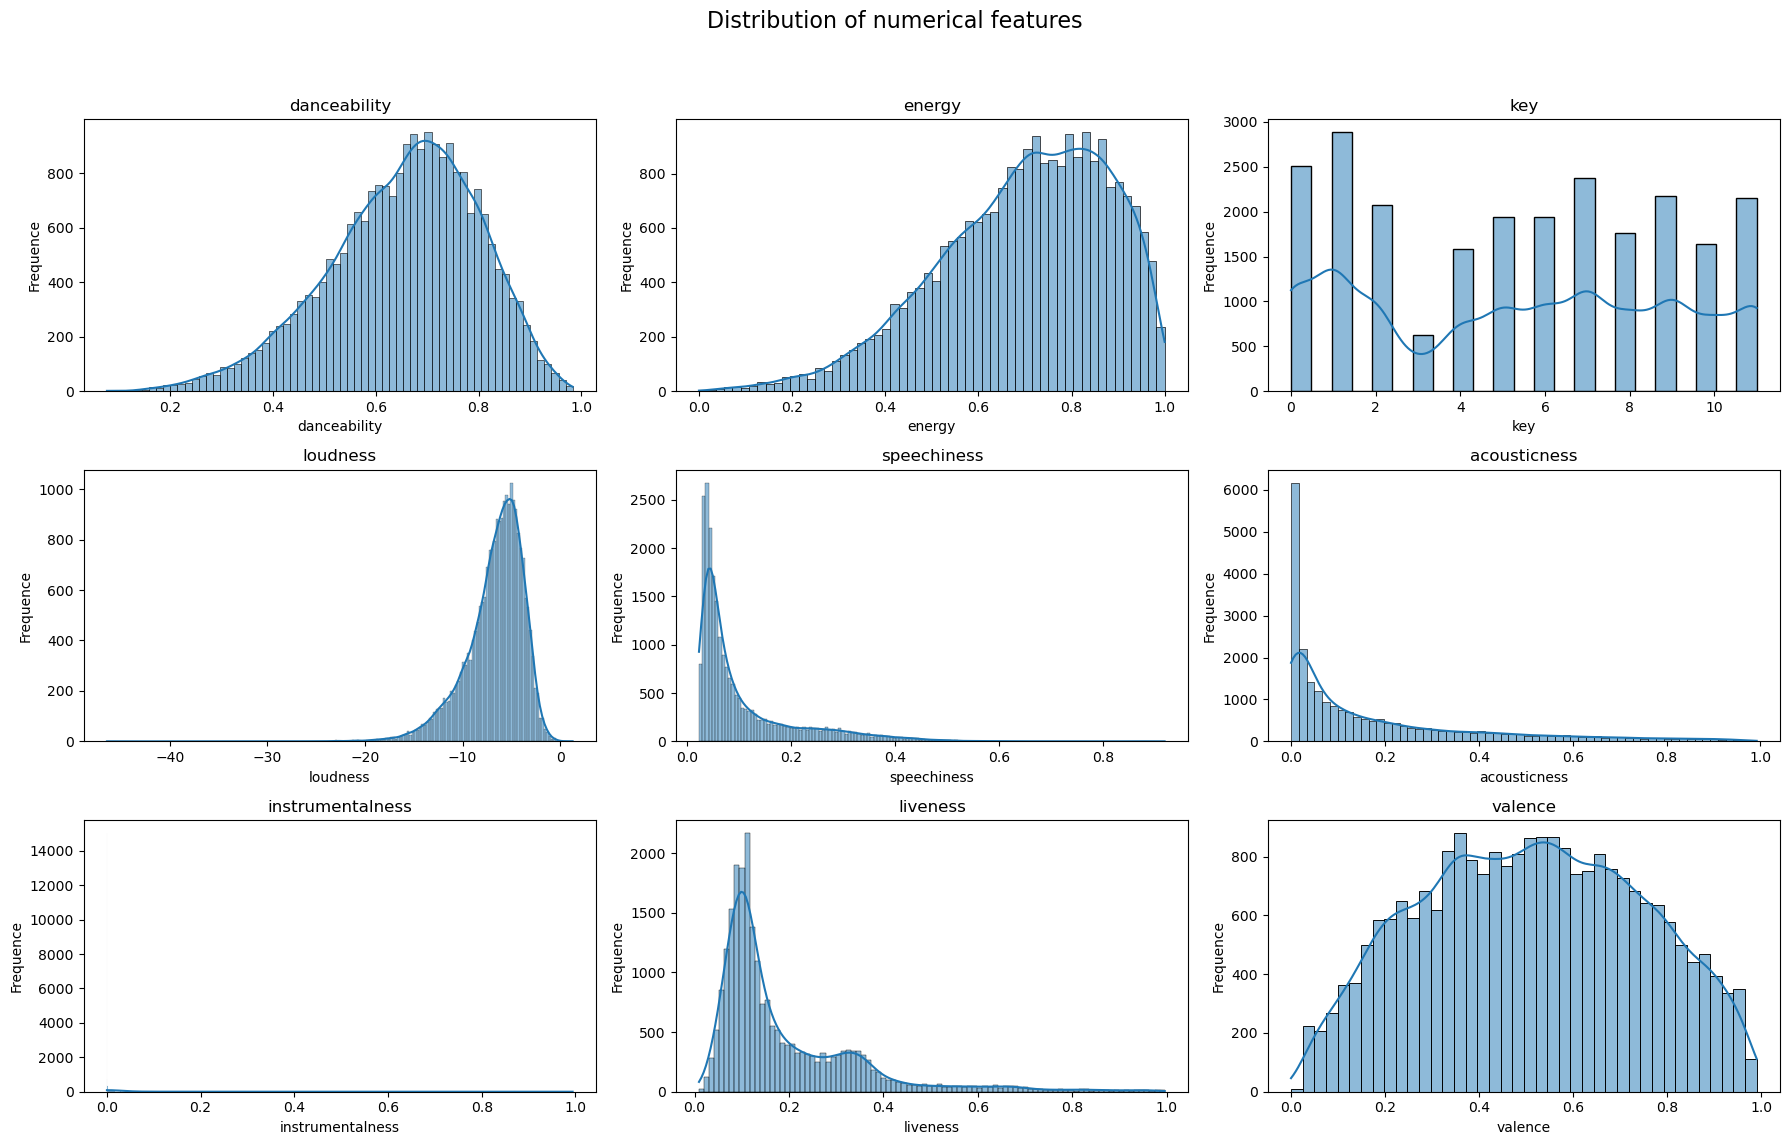

In [34]:
fig, axes = plt.subplots(len(numeric_features) // 3, 3, figsize=(18, 12))
fig.suptitle("Distribution of numerical features", fontsize=16)

for ax, feature in zip(axes.flatten(), numeric_features):
    sns.histplot(X_train[feature], kde=True, ax=ax)
    ax.set_title(feature)
    ax.set_ylabel("Frequence")

plt.tight_layout(
    rect=[0, 0.03, 1, 0.95]
) 

plt.show()

Here is a statistical summary for numerical features

In [35]:
print(X_train.describe())  

       danceability        energy           key      loudness          mode  \
count  23639.000000  23639.000000  23639.000000  23639.000000  23639.000000   
mean       0.653895      0.698787      5.365752     -6.718641      0.565887   
std        0.145663      0.181464      3.613953      2.978725      0.495650   
min        0.077100      0.000175      0.000000    -46.448000      0.000000   
25%        0.562000      0.581000      2.000000     -8.189500      0.000000   
50%        0.670000      0.722000      6.000000     -6.174000      1.000000   
75%        0.760000      0.841000      9.000000     -4.646000      1.000000   
max        0.983000      1.000000     11.000000      1.275000      1.000000   

        speechiness  acousticness  instrumentalness      liveness  \
count  23639.000000  23639.000000      23639.000000  23639.000000   
mean       0.106417      0.175867          0.085507      0.190080   
std        0.101116      0.220216          0.225233      0.154489   
min        0

Regarding the categorical features now, here are their distributions : 

c:\Users\PC\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


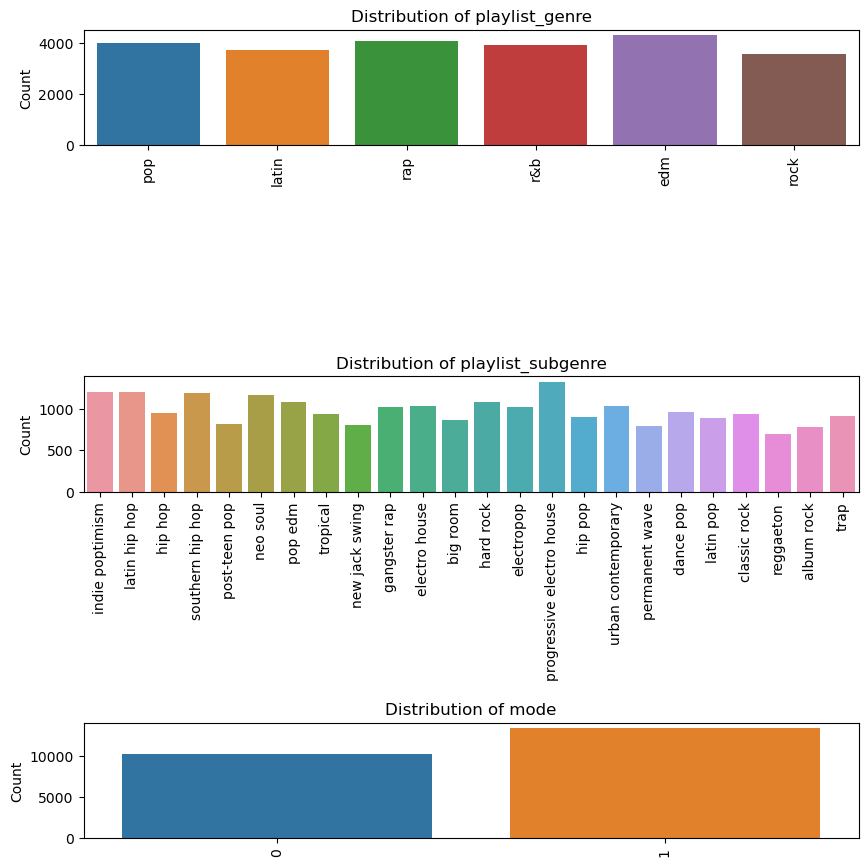

In [36]:
fig_height = (
    len(categorical_features) * 4
)  

fig, axes = plt.subplots(
    len(categorical_features),
    1,
    figsize=(10, fig_height),
    tight_layout=True,
    gridspec_kw={
        "hspace": 0.5
    },  
)

for ax in axes:
    box = ax.get_position()
    ax.set_position(
        [box.x0, box.y0, box.width, box.height * 0.5]
    ) 

for i, cat in enumerate(categorical_features):
    sns.countplot(x=cat, data=X_train, ax=axes[i])
    axes[i].set_title(f"Distribution of {cat}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis="x", rotation=90)

plt.show()

Our target variable is the song popularity, it ranges from 0 to 100. It can then take 101 different values. You can observe here its distribution. We can see that a lot of songs have a popularity of 0 as most songs on Spotify are never listened.

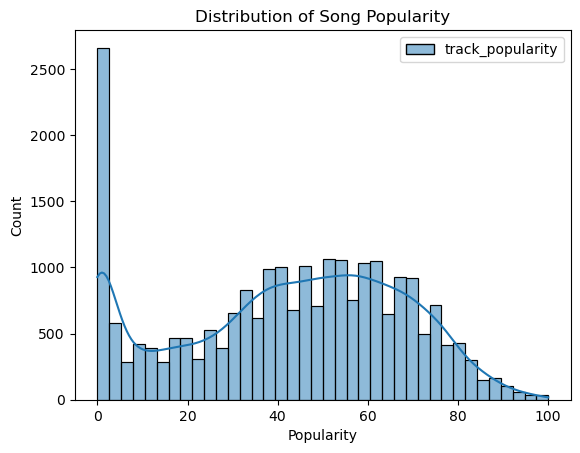

In [39]:
sns.histplot(y_train, kde=True)
plt.title("Distribution of Song Popularity")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

You can see the correlation between the categorical variables on this heatmap : 

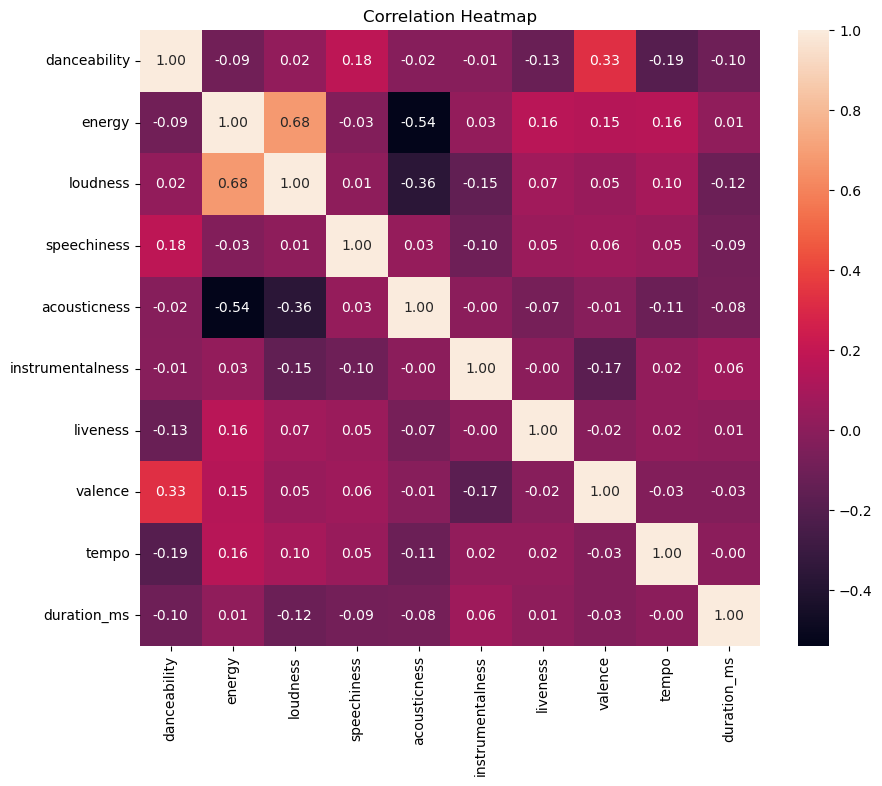

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    X_train[
        [
            "danceability",
            "energy",
            "loudness",
            "speechiness",
            "acousticness",
            "instrumentalness",
            "liveness",
            "valence",
            "tempo",
            "duration_ms",
        ]
    ].corr(),
    annot=True,
    fmt=".2f",
)
plt.title("Correlation Heatmap")
plt.show()

# Base Model

As an example, we implemented a simple random forest regressor 

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

As said earlier, we do not keep the identifying columns

In [42]:
features = numeric_features + categorical_features
X_train = X_train[features]

We apply a StandardScaler to our numerical features and a one hot encoding to out categorical features. Then, we add to this pipeline a random forest regressor

In [43]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])


In [44]:
pipeline.fit(X_train, y_train)

c:\Users\PC\anaconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['playlist_genre',
                                                   'playlist_subgenre',
                                                   'mode'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

Here is the benchmark you will have to outperform in this challenge : 

In [45]:
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"RMSE on training data: {rmse_train}")

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE on test data: {rmse_test}")

RMSE on training data: 8.24210103578049
RMSE on test data: 21.10746793688402


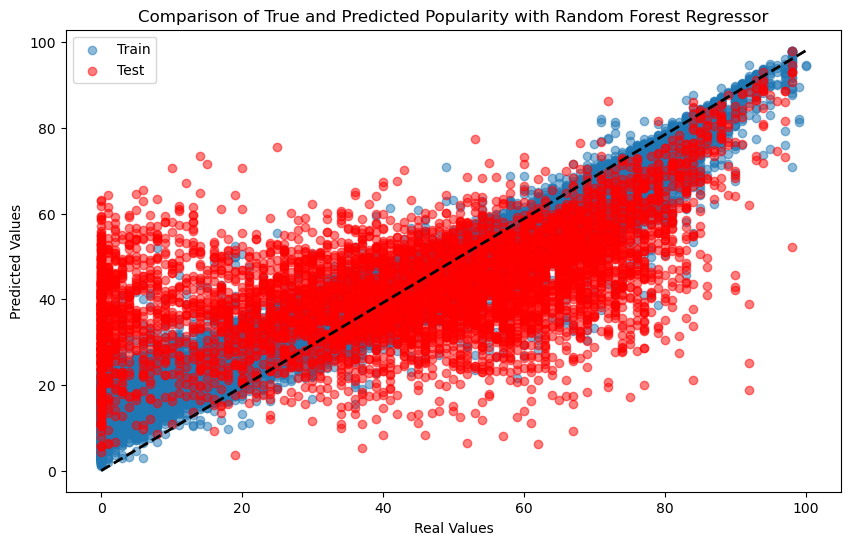

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, alpha=0.5, label="Train")
plt.scatter(y_test, y_pred_test, alpha=0.5, label="Test", color="r")
plt.title("Comparison of True and Predicted Popularity with Random Forest Regressor")
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.plot(
    [y_train.min(), y_train.max()], [y_test.min(), y_test.max()], "k--", lw=2
)  
plt.legend()
plt.show()

## Submitting to the online challenge: [ramp.studio](https://ramp.studio) <a class="anchor" id="submitting"></a>

Once you found a good model, you can submit them to [ramp.studio](https://www.ramp.studio) to enter the online challenge. First, if it is your first time using the RAMP platform, [sign up](https://www.ramp.studio/sign_up), otherwise [log in](https://www.ramp.studio/login). Then sign up to the event [hotjupiter](http://www.ramp.studio/events/hotjupiter_datacamp2023). Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](https://www.ramp.studio/events/hotjupiter_datacamp2023/sandbox) and write the code for your classifier directly on the browser. You can also create a new folder `my_submission` in the `submissions` folder containing `classifier.py` and upload this file directly. You can check the starting-kit ([`classifier.py`](/edit/submissions/starting_kit/classifier.py)) for an example. The submission is trained and tested on our backend in the similar way as `ramp-test` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](https://www.ramp.studio/events/hotjupiter_datacamp2023/my_submissions). Once it is trained, your submission shows up on the [public leaderboard](https://www.ramp.studio/events/hotjupiter_datacamp2023/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp-test`), it will show up in the "Failed submissions" table in [my submissions](https://www.ramp.studio/events/hotjupiter_datacamp2023/my_submissions). You can click on the error to see part of the trace.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, etc., _locally_, and checking them with `ramp-test`. The script prints mean cross-validation scores.

The official score in this RAMP (the first score column on the [leaderboard](http://www.ramp.studio/events/hotjupiter_datacamp2023/leaderboard)) is the balenced accuracy score (`bal_acc`). When the score is good enough, you can submit it at the RAMP.

Here is the script proposed as the starting_kit:

In [28]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor


class Regressor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.features = [
            "danceability",
            "energy",
            "key",
            "loudness",
            "mode",
            "speechiness",
            "acousticness",
            "instrumentalness",
            "liveness",
            "valence",
            "tempo",
            "duration_ms",
            "playlist_genre",
            "playlist_subgenre",
        ]

        numeric_features = self.features[
            :-2
        ]  # Assuming the last two are categorical
        categorical_features = self.features[-2:]

        numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
        categorical_transformer = Pipeline(
            steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
        )

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer, categorical_features),
            ]
        )

        self.model = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                (
                    "regressor",
                    RandomForestRegressor(n_estimators=100, random_state=42),
                ),
            ]
        )

    def _convert_array_to_df(self, X):
        """Converts a numpy array to a pandas DataFrame with the correct column names."""
        return pd.DataFrame(X, columns=self.features)

    def fit(self, X, y):
        X_df = self._convert_array_to_df(X)
        self.model.fit(X_df, y)

    def predict(self, X):
        X_df = self._convert_array_to_df(X)
        return self.model.predict(X_df)


You can test your solution locally by running the ramp-test command followed by --submission <my_submission folder>.
Here is an example with the starting_kit submission:

In [66]:
!ramp-test --submission starting_kit

Testing Spotify Popularity Prediction
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/rampwf/score_types/mare.py:15: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true))
	score   rmse  mare       time
	train   8.23   inf  26.108286
	valid  21.72   inf   0.524588
	test   21.32   inf   0.149517
CV fold 1
/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/rampwf/score_types/mare.py:15: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true))
	score   rmse  mare       time
	train   8.23   inf  26.112372
	valid  21.73   inf   0.543580
	test   21.22   inf   0.153153
----------------------------
Mean CV scores
----------------------------
/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid val